In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import cvxpy as cp
import apimoex
from datetime import datetime, timedelta
from sklearn.covariance import LedoitWolf

# P.s Да в названии репо ошибка, но так ее никто из других кандидатов на стажировку не найдет)

# Задаем диапозон дат для выгрузки котировок

In [ ]:
end = datetime.now().date()
start = end - timedelta(days=182)  # 6 месяцев

# 1. Получаем список голубых фишек IMOEX через ISS statistics API
def get_imoex_constituents():
    url = (
        "https://iss.moex.com/iss/statistics/engines/stock/markets/index/analytics/IMOEX.json"
    )
    j = requests.get(url).json()
    cols = [c.lower() for c in j['analytics']['columns']]
    df = pd.DataFrame(j['analytics']['data'], columns=cols)
    sec_col = next(c for c in df.columns if 'sec' in c or 'ticker' in c)
    return df[sec_col].tolist()

tickers = get_imoex_constituents()

print(f'Найдено тикеров: {len(tickers)}, \n{tickers}')

# 2. Загрузка сырых цен через apimoex
prices = pd.DataFrame()
with requests.Session() as session:
    for t in tickers:
        data = apimoex.get_board_history(session, t, start=start.isoformat(), end=end.isoformat())
        df_hist = pd.DataFrame(data)
        df_hist["TRADEDATE"] = pd.to_datetime(df_hist["TRADEDATE"])
        df_hist.set_index("TRADEDATE", inplace=True)
        prices[t] = df_hist["CLOSE"]

# Сохраняем сырые цены
# prices.to_csv('raw_prices.csv', index_label='date')


Найдено тикеров: 20, 
['AFKS', 'AFLT', 'ALRS', 'ASTR', 'BSPB', 'CBOM', 'CHMF', 'ENPG', 'FEES', 'FLOT', 'GAZP', 'GMKN', 'HEAD', 'HYDR', 'IRAO', 'LKOH', 'MAGN', 'MDMG', 'MOEX', 'MSNG']


# Выгружаем сплиты если они были

In [ ]:
# 3. Корректировка на сплиты
adj_prices = prices.copy()
all_splits = []

def fetch_splits(ticker):
    j = requests.get(
        f"https://iss.moex.com/iss/engines/stock/markets/shares/securities/{ticker}/corporate-actions.json"
    ).json()
    corp = j.get("corporateActions", {})
    data = corp.get("data") or []
    cols = corp.get("columns") or []
    if not data or not cols:
        return pd.DataFrame(columns=["ACTIONDATE","RATIO"])
    df = pd.DataFrame(data, columns=cols)
    if "ACTIONCODE" not in df or "RATIO" not in df:
        return pd.DataFrame(columns=["ACTIONDATE","RATIO"])
    return df[df["ACTIONCODE"].str.startswith("SP")][["ACTIONDATE","RATIO"]]

splits_records = []
for t in tickers:
    splits = fetch_splits(t)
    if not splits.empty:
        splits["ticker"] = t
        splits_records.append(splits)
        for _, row in splits.iterrows():
            dt_split = pd.to_datetime(row.ACTIONDATE)
            adj_prices.loc[adj_prices.index < dt_split, t] /= float(row.RATIO)

if splits_records:
    pd.concat(splits_records).to_csv('splits_summary.csv', index=False)
else:
    print('Сплиты за выбранный диапозон не найдены')

# Сохраняем скорректированные цены
# adj_prices.to_csv('adjusted_prices.csv', index_label='date')

Сплиты за выбранный диапозон не найдены


# Вычисляем доходность, ковариационную матрицу и строим MV портфель 

In [5]:
# 4. Доходности (только по скорректированным ценам)
returns = adj_prices.pct_change(fill_method=None).dropna()

# 5. Covariance & expected returns
lw = LedoitWolf().fit(returns)
Sigma = pd.DataFrame(lw.covariance_, index=returns.columns, columns=returns.columns) * 252
mu = returns.mean() * 252

# 6. Long-only MV оптимизация
n = len(tickers)
w = cp.Variable(n)
lam = 0.1
objective = cp.Maximize(mu.values @ w - lam * cp.quad_form(w, Sigma.values))
constraints = [cp.sum(w)==1, w>=0, w<=0.2]
prob = cp.Problem(objective, constraints)
prob.solve()
w_opt = pd.Series(w.value, index=tickers)
print("Long-only MV weights:\n", w_opt.round(4))

# 7. Расчет портфеля
portf_ret = returns[tickers].dot(w_opt)
portf_value = (1+portf_ret).cumprod()
cum_ret = portf_value.iloc[-1]
ann_ret = portf_ret.mean()*252
ann_vol = portf_ret.std()*np.sqrt(252)
sharpe = ann_ret/ann_vol
print(f"Cumulative return: {cum_ret:.4f}")
print(f"Annualized Return: {ann_ret:.4f}, Volatility: {ann_vol:.4f}, Sharpe: {sharpe:.4f}")


Long-only MV weights:
 AFKS    0.2000
AFLT    0.2000
ALRS   -0.0000
ASTR    0.0000
BSPB    0.0128
CBOM    0.1872
CHMF   -0.0000
ENPG    0.2000
FEES    0.0000
FLOT    0.0000
GAZP    0.0000
GMKN    0.0000
HEAD    0.0000
HYDR    0.0000
IRAO    0.0000
LKOH    0.0000
MAGN   -0.0000
MDMG    0.2000
MOEX    0.0000
MSNG    0.0000
dtype: float64
Cumulative return: 1.1323
Annualized Return: 0.3075, Volatility: 0.3336, Sharpe: 0.9218


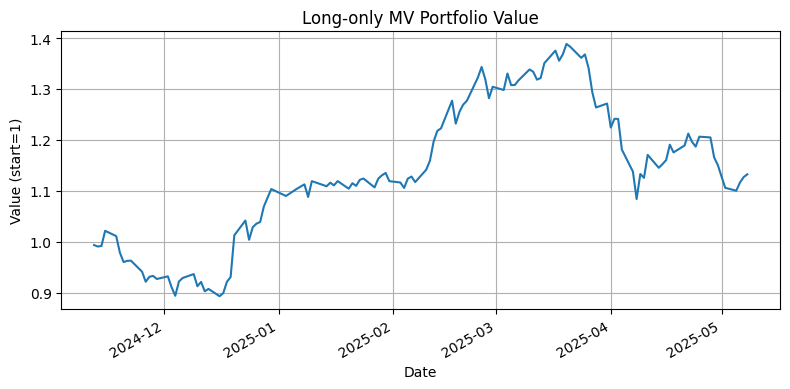

In [6]:
# 8. График
plt.figure(figsize=(8,4))
portf_value.plot()
plt.title("Long-only MV Portfolio Value")
plt.ylabel("Value (start=1)")
plt.xlabel("Date")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
status = prob.solve()
print("Solver status:", prob.status)  # optimal, infeasible и т. п.


Solver status: optimal
